In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from chisq import EclipseFit
from etv_plots import Plotter
from cbp_utils import im, g1
from im_g1_fit import parallel_apply_along_axis, combine_params, reduced_fit
plt.rcParams.update({'font.size': 24})

In [2]:
fit = EclipseFit('5095')

In [3]:
# Our solution
x = np.array([18.6108497, 66.8620090, np.radians(85.571), 0.486, np.radians(108.2), 
              239.49,  95.923, 3.762e-02, -4.031e-02, np.radians(83.46), np.radians(0.341), 
              1.0887, 1.0372, 4.58337407e-03, 0.0, 4.515, 77.5])

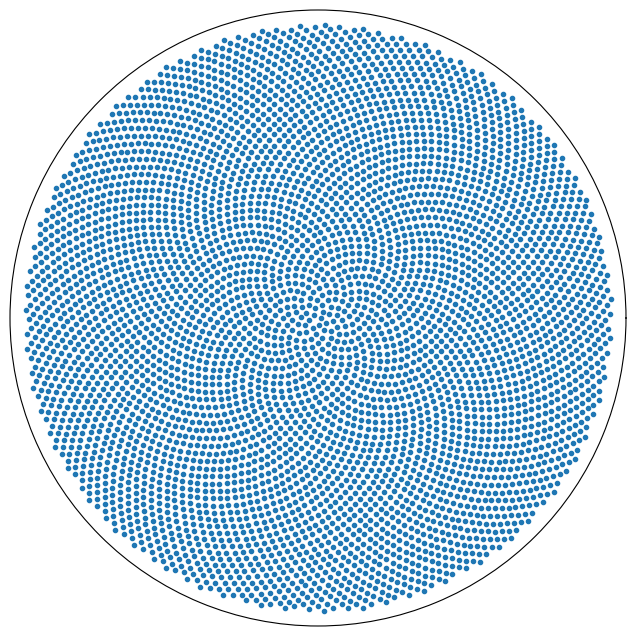

In [4]:
N = 5000
phi = (1 + np.sqrt(5))/2
ims = np.radians(180) * np.sqrt(np.arange(N) + 1/2)/np.sqrt(N + 1/2)
g1s = 2*np.pi*np.arange(N)/phi**2
# enjoy the pleasant sunflower pattern
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,8))
ax.scatter(g1s, np.degrees(ims), marker='.')
ax.set_rticks([]); ax.set_thetagrids([]);

In [5]:
# planet phase shouldn't matter, so I don't compute it correctly
tp = 158.9
# Orbital solution from Borkovits et al. 2016, assuming equal mass binary
borko = [18.61196, 66.8735, np.radians(86), 0.05, np.radians(270),
         236.26, tp, 0.071*np.cos(np.radians(324)), 0.071*np.sin(np.radians(324)), np.radians(73), np.radians(39),
         1.0, 1.0, 0.018, 0.0, 0.0, 0.0]

# Orbital solution from Getley et al. 2017
getley = [18.61196, 66.8735, np.radians(80), 0.246, np.radians(22.82),
          237.70817, tp, 0.0604*np.cos(np.radians(27.67)), 0.0604*np.sin(np.radians(27.67)), np.radians(105.92), np.radians(64.19 - 305.54),
          1.21, 0.51, 7.698/1047.5, 0.0, 0.0, 0.0]

print(f"Borkovits solution: i_m = {np.degrees(im(borko[2], borko[9], borko[10])):.3f} g_1 = {np.degrees(g1(borko[2], borko[9], borko[10], borko[4])):.3f}")
print(f"Getley solution: i_m = {np.degrees(im(getley[2], getley[9], getley[10])):.3f}, g_1 = {np.degrees(g1(getley[2], getley[9], getley[10], getley[4])):.3f}")
print(f"Goldberg solution: i_m = {np.degrees(im(x[2], x[9], x[10])):.3f}, g_1 = {np.degrees(g1(x[2], x[9], x[10], x[4])):.3f}")

Borkovits solution: i_m = 40.379 g_1 = 158.273
Getley solution: i_m = 120.112, g_1 = -54.488
Goldberg solution: i_m = 2.138, g_1 = -62.681


In [6]:
reduced_fit_results = pickle.load(open('im_g1_fit_out/im_g1_fit.data', 'rb'))

for result in reduced_fit_results:
    if not result['success']:
        print(result)

In [7]:
red_ims = np.asarray([result['angles'][0] for result in reduced_fit_results])
red_g1s = np.asarray([result['angles'][1] for result in reduced_fit_results])
etv_chisqs = np.asarray([result['fun'] if result['success'] else np.nan for result in reduced_fit_results])

In [8]:
def dbdt_fit(i):
    result = reduced_fit_results[i[0]]
    ecl_model, rv_model = fit.get_residuals(combine_params(result['x'], x, result['angles']))
    b_reg = fit.impact_regression(ecl_model)
    return b_reg[0]['A'], b_reg[1]['A']

In [9]:
try:
    dbdt_fit_arr = np.load('im_g1_fit_out/im_g1_fit_impact_parameter.npy')
except:
    dbdt_fit_arr = parallel_apply_along_axis(dbdt_fit, 1, np.arange(5000)[:,np.newaxis])
    np.save('im_g1_fit_out/im_g1_fit_impact_parameter.npy', dbdt_fit_arr)
b_chisqs = ((fit.b0_data['A'] - dbdt_fit_arr[:,1])/fit.b0_err['A'])**2 + ((fit.dbdt_data['A'] - dbdt_fit_arr[:,0])/fit.dbdt_err['A'])**2

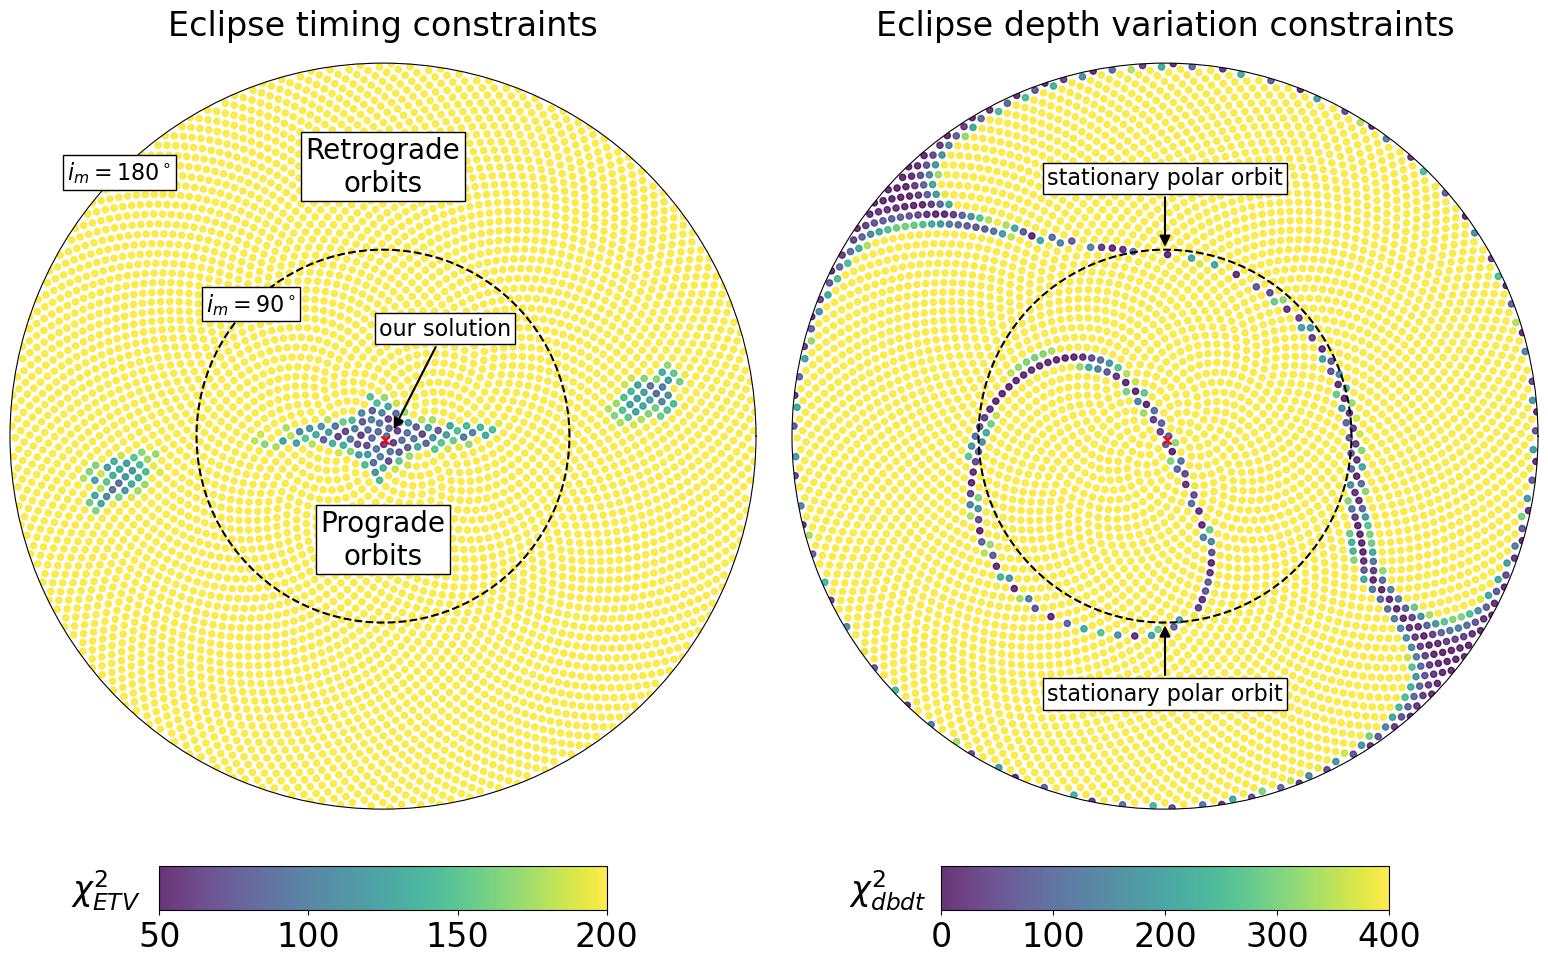

In [10]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(16,12))

img = axs[0].scatter(red_g1s, np.degrees(red_ims), c=etv_chisqs, s=20, alpha=0.8,
                cmap=plt.get_cmap('viridis'), vmin=50, vmax=200)
cbar0 = fig.colorbar(img, ax=axs[0], ticks=[50.,100.,150.,200.], aspect=10, shrink=0.6, orientation='horizontal', pad=0.05)
img = axs[1].scatter(g1s, np.degrees(ims), c=b_chisqs, s=20, alpha=0.8,
                cmap=plt.get_cmap('viridis'), vmin=0, vmax=400)
cbar1 = fig.colorbar(img, ax=axs[1], aspect=10, shrink=0.6, orientation='horizontal', pad=0.05)

cbar0.set_label('$\chi^2_{ETV}$', fontsize=24, labelpad=-45, x=-0.12, ha='center', va='center')
cbar1.set_label(r"$\chi^2_{dbdt}$", fontsize=24, labelpad=-45, x=-0.12, ha='center', va='center')

for i in (0,1):
    axs[i].plot(np.linspace(0, 2*np.pi, 100), 90.0*np.ones(100), color='k', linestyle='--')
    axs[i].grid(False)
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_ylim([0, 180])
    axs[i].scatter([g1(x[2], x[9], x[10], x[4])], [np.degrees(im(x[2], x[9], x[10]))], color='r', marker='x')

axs[1].annotate('stationary polar orbit', xy=(np.pi/2, 90), xycoords='data',
                xytext=(np.pi/2, 130),
                arrowprops=dict(arrowstyle='-|>', fc='k', lw=1.5),
                horizontalalignment='center', verticalalignment='top', fontsize=16, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})
axs[1].annotate('stationary polar orbit', xy=(3*np.pi/2, 90), xycoords='data',
                xytext=(3*np.pi/2, 130),
                arrowprops=dict(arrowstyle='-|>', fc='k', lw=1.5),
                horizontalalignment='center', verticalalignment='bottom', fontsize=16, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})

axs[0].annotate('our solution', xy=(np.radians(25), 5),
                xytext=(np.radians(60), 60),
                arrowprops=dict(arrowstyle='-|>', fc='k', ec='k', lw=1.5),
                horizontalalignment='center', verticalalignment='center', fontsize=16, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})

axs[0].text(3*np.pi/4, 90, '$i_m=90^\circ$', ha='center', va='center', fontsize=16, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})
axs[0].text(3*np.pi/4, 180, '$i_m=180^\circ$', ha='center', va='center', fontsize=16, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})
axs[0].text(np.pi/2, 130, 'Retrograde\norbits', ha='center', va='center', fontsize=20, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})
axs[0].text(3*np.pi/2, 50, 'Prograde\norbits', ha='center', va='center', fontsize=20, bbox={'edgecolor':'k', 'facecolor':'w', 'pad':3})

axs[0].set_title('Eclipse timing constraints', fontsize=24, pad=20)
axs[1].set_title('Eclipse depth variation constraints', fontsize=24, pad=20)

plt.tight_layout()
# plt.savefig('figures/combined_constraint.pdf')

### Find some good solutions in the islands 

Index 2588
i_m = 129.506, g_1 = 190.093
ETV chisq: 88.695 

Index 2749
i_m = 133.473, g_1 = 8.843
ETV chisq: 85.741 

Parameters: [ 2.36437322e+02  9.59483236e+01 -2.51198393e-02  7.27031390e-02
  6.34292928e-03]
ETV chisq: 85.741
Sigma from measured db/dt: -208.948


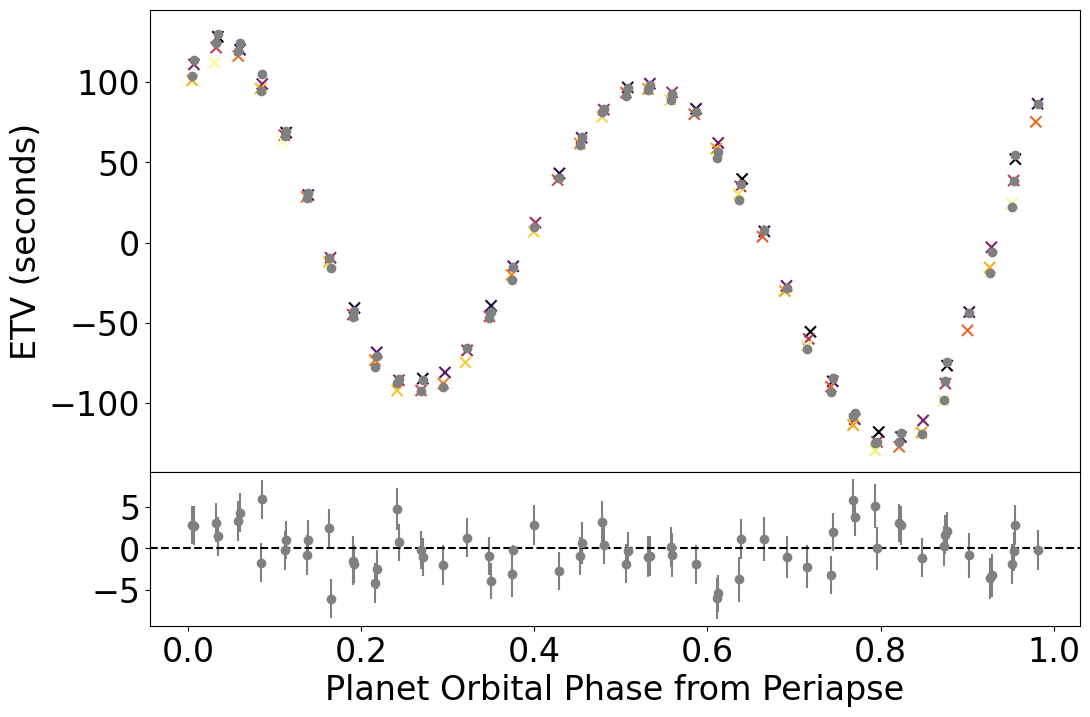

In [11]:
for i, result in enumerate(reduced_fit_results):
    if result['angles'][0] > np.radians(90) and result['fun'] < 90:
        print('Index', i)
        print(f"i_m = {np.degrees(result['angles'][0]):.3f}, g_1 = {np.remainder(np.degrees(result['angles'][1]), 360):.3f}")
        print(f'ETV chisq: {result["fun"]:.3f}', '\n')

# plot one of them
plot = Plotter('5095')
result = reduced_fit_results[2749]
plot.etv_residuals(combine_params(result['x'], x, result['angles']), 'A', phased=True, linearize=True)
print(f"Parameters: {result['x']}")
print(f"ETV chisq: {result['fun']:0.3f}")

ecl_model, rv_model = fit.get_residuals(combine_params(result['x'], x, result['angles']))
print(f"Sigma from measured db/dt: {(fit.impact_regression(ecl_model)[0]['A'] - fit.dbdt_data['A'])/fit.dbdt_err['A']:.3f}")

### Zoomed in fit

In [12]:
import pickle
dense_reduced_fit_results = pickle.load(open('im_g1_fit_out/im_g1_fit_dense.data', 'rb'))

for result in dense_reduced_fit_results:
    if not result['success']:
        print(result)

In [13]:
dense_red_ims = np.asarray([result['angles'][0] for result in dense_reduced_fit_results])
dense_red_g1s = np.asarray([result['angles'][1] for result in dense_reduced_fit_results])
dense_etv_chisqs = np.asarray([result['fun'] if result['success'] else np.nan for result in dense_reduced_fit_results])

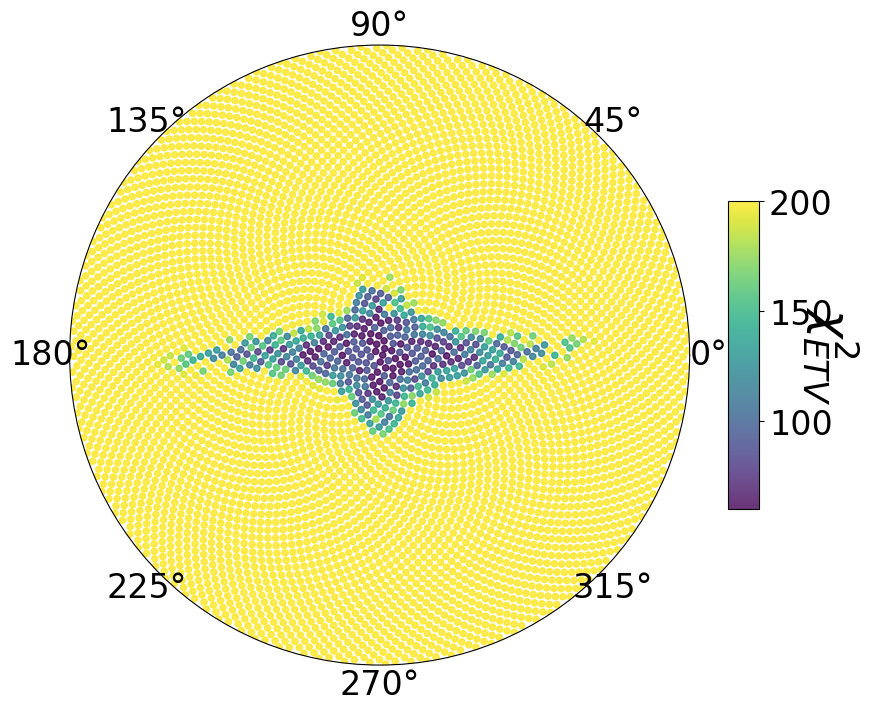

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(10,10))
img = ax.scatter(dense_red_g1s, np.degrees(dense_red_ims), c=dense_etv_chisqs, s=20, alpha=0.8,
                cmap=plt.get_cmap('viridis'), #norm=colors.LogNorm(vmin=60, vmax=1000))
                 vmin=60, vmax=200)

ax.grid(False)
ax.set_yticklabels([])
ax.set_ylim([0, 90])
cbar = plt.colorbar(img, aspect=10, shrink=0.4)
cbar.set_label('$\chi^2_{ETV}$', rotation=270, fontsize='x-large', labelpad=20)
# plt.savefig('figures/im_g1_fit_zoomed.pdf', dpi='figure')

### Plot on sphere

In [15]:
N = 5000
ims = np.zeros(0)
g1s = np.zeros(0)

# Create a sphere
a = 4*np.pi/N
d = np.sqrt(a)
M_theta = int(np.round(np.pi/d))
d_theta = np.pi/M_theta
d_phi = a/d_theta
for m in range(M_theta):
    theta = np.pi*(m + 0.5)/M_theta
    M_phi = int(np.round(2*np.pi*np.sin(theta)/d_phi))
    for n in range(M_phi):
        phi = 2*np.pi*n/M_phi
        ims = np.append(ims, theta)
        g1s = np.append(g1s, phi)

In [16]:
try:
    dbdt_im_g1_sphere = np.load('im_g1_fit_out/im_g1_sphere.npy')
except:
    dbdt_im_g1_sphere = parallel_apply_along_axis(reduced_fit, 0, np.vstack((ims, g1s)))

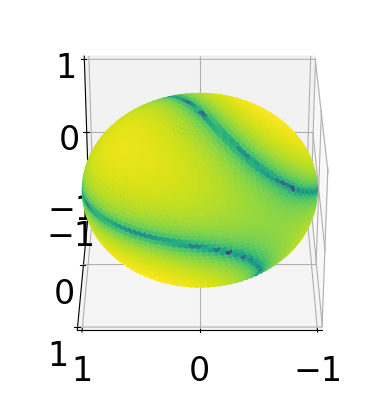

In [17]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

xx = np.sin(ims)*np.cos(g1s)
yy = np.sin(ims)*np.sin(g1s)
zz = np.cos(ims)

sigmas = np.abs((dbdt_im_g1_sphere - 3.99e-07)/1.69e-7)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init():

    img = ax.scatter(xx, yy, zz, c=sigmas, s=20,
                    cmap=plt.get_cmap('viridis'), norm=colors.LogNorm(vmin=sigmas.min(), vmax=sigmas.max()))

    ax.scatter([0], [0], [1], c='red')
    ax.scatter([0], [0], [-1], c='black')
    ax.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), np.zeros(100), color='k', linestyle='--')

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.view_init(azim=90)
    return fig,

def animate(i: int):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
# anim.save('figures/basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

#plt.show()